#### **Full Spectrum Plotting**

This notebook creates a spectrum from the 

In [1]:
import pandas as pd
import pyopenms as oms

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from scipy.signal import savgol_filter
from bokeh.io import output_notebook, show
import matplotlib.pyplot as plt

output_notebook()

# set global plotting backend for pandas
pd.options.plotting.backend = "ms_matplotlib" # one of: "ms_bokeh" "ms_matplotlib" "ms_plotly"
pd.set_option('display.width',500)

if pd.options.plotting.backend in ["ms_matplotlib", "ms_bokeh"]:
    title_font_size = 20
    xaxis_label_font_size = 30
    yaxis_label_font_size = 30
    xaxis_tick_font_size = 28
    yaxis_tick_font_size = 28
    annotation_font_size = 16
else:
    title_font_size = 28
    xaxis_label_font_size = 26
    yaxis_label_font_size = 26
    xaxis_tick_font_size = 24
    yaxis_tick_font_size = 24
    annotation_font_size = 24

Loading BokehJS ...

In [3]:
# # Download test file
import requests

url = 'https://raw.githubusercontent.com/Roestlab/massdash/dev/test/test_data/featureMap/ionMobilityTestFeatureDfEntireSpectra.tsv'
file_name = 'ionMobilityTestFeatureDfEntireSpectra.tsv'

# Send a GET request to the URL
response = requests.get(url)

# # Save the content of the response to a file
with open(file_name, 'wb') as file:
    file.write(response.content)

print(f'File {file_name} downloaded successfully!')

url = 'https://raw.githubusercontent.com/Roestlab/massdash/dev/test/test_data/featureMap/ionMobilityTestFeatureDf.tsv'
file_name = 'ionMobilityTestFeatureDf.tsv'

# Send a GET request to the URL
response = requests.get(url)

# # Save the content of the response to a file
with open(file_name, 'wb') as file:
    file.write(response.content)

print(f'File {file_name} downloaded successfully!')

File ionMobilityTestFeatureDfEntireSpectra.tsv downloaded successfully!
File ionMobilityTestFeatureDf.tsv downloaded successfully!


In [4]:
df_ms_experiment_all = pd.read_csv("./ionMobilityTestFeatureDfEntireSpectra.tsv", sep="\t")
df_ms_experiment_all = df_ms_experiment_all[(df_ms_experiment_all['ms_level'] == 2) & (df_ms_experiment_all['rt'].between(6243.034, 6243.035))].drop(columns=['Annotation', 'product_mz', 'native_id', 'precursor_mz', 'rt', 'ms_level'])

df_ms_experiment_extracted = pd.read_csv("./ionMobilityTestFeatureDf.tsv", sep='\t')

df_ms_experiment = df_ms_experiment_all.merge(df_ms_experiment_extracted, how='left')

In [5]:
### 
# print(df_ms_experiment.head())

peptide = "AFVDFLSDEIK"
charge = 2

seq = oms.AASequence.fromString(peptide)

ion_annotations = ['prec', 'y4^1', 'y5^1', 'y6^1', 'y7^1', 'y8^1', 'y9^1']
ion_ordinals = [4, 5, 6, 7, 8, 9]

print("=" * 35)
print("precursor mz:", round(seq.getMZ(charge), 4))

ion_formula = [peptide]
ion_mz = [round(seq.getMZ(charge), 4)]
for ion in ion_ordinals:
    suffix = seq.getSuffix(ion) 
    # print(f"y{ion} ion sequence: {suffix}")
    y3_formula = suffix.getFormula(oms.Residue.ResidueType.YIon, 1)  # y3++ ion
    # print(f"y{ion} mz: {round(suffix.getMZ(1), 4)}")
    ion_formula.append(suffix)
    ion_mz.append(round(suffix.getMZ(1), 4))
annotation_df = pd.DataFrame({'Annotation':ion_annotations, 'product_mz':ion_mz, 'sequence':ion_formula})
print(annotation_df)

df = pd.merge(df_ms_experiment[['ms_level', 'mz', 'rt', 'im', 'int', 'precursor_mz', 'product_mz', 'Annotation']], annotation_df, on=['Annotation', 'product_mz'], how='left')
# # df['sequence'] = peptide
# #/ df['precursor_charge'] = charge
df.rename(columns={'Annotation':'ion_annotation'}, inplace=True)

precursor mz: 642.3295
  Annotation  product_mz     sequence
0       prec    642.3295  AFVDFLSDEIK
1       y4^1    504.2664         DEIK
2       y5^1    591.2984        SDEIK
3       y6^1    704.3825       LSDEIK
4       y7^1    851.4509      FLSDEIK
5       y8^1    966.4779     DFLSDEIK
6       y9^1   1065.5463    VDFLSDEIK


In [6]:
df.dropna()['ion_annotation'].drop_duplicates()

11279    y4^1
17668    y5^1
23308    y6^1
27790    y7^1
30723    y8^1
33529    y9^1
Name: ion_annotation, dtype: object

In [7]:
df = df.fillna('')
df['sequence'] = df['sequence'].astype(str)

In [8]:
df_new = df[['mz', 'ion_annotation', 'int']].groupby(['mz', 'ion_annotation']).sum().reset_index()

/home/joshua/Development/pyopenms_viz/pyopenms_viz/_matplotlib/core.py:102: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(self.grid, zorder=0)


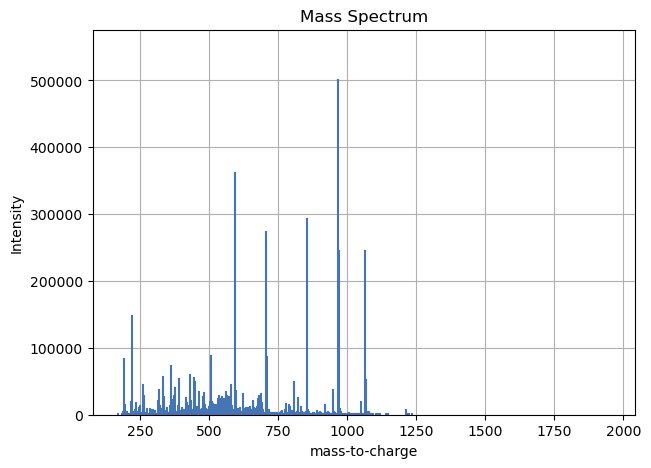

In [9]:
p = df_new.plot(kind="spectrum", x="mz", y="int", 
        #ion_annotation="ion_annotation", 
        annotate_mz=False, grid=False, width=700, 
        annotate_top_n_peaks=5, bin_method='none', num_x_bins=500,
        title_font_size = title_font_size,
        xaxis_label_font_size = xaxis_label_font_size,
        yaxis_label_font_size = yaxis_label_font_size,
        xaxis_tick_font_size = xaxis_tick_font_size,
        yaxis_tick_font_size = yaxis_tick_font_size,
        annotation_font_size = annotation_font_size
        )

/home/joshua/Development/pyopenms_viz/pyopenms_viz/_matplotlib/core.py:102: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(self.grid, zorder=0)


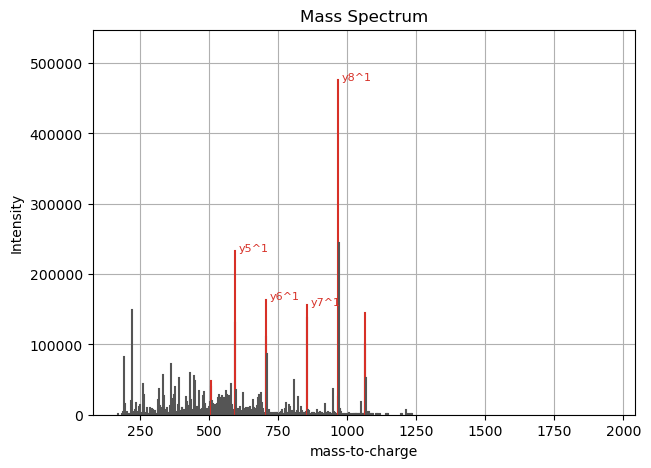

In [10]:
p = df_new.plot(kind="spectrum", x="mz", y="int", 
        ion_annotation="ion_annotation",
        annotate_mz=False, grid=False, width=700, num_x_bins=500, bin_method='none',
        annotate_top_n_peaks=5,
        title_font_size = title_font_size,
        xaxis_label_font_size = xaxis_label_font_size,
        yaxis_label_font_size = yaxis_label_font_size,
        xaxis_tick_font_size = xaxis_tick_font_size,
        yaxis_tick_font_size = yaxis_tick_font_size,
        annotation_font_size = annotation_font_size
        )